# Task 4 Time Series Analysis
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to extract the time series


In [4]:
import numpy as np
import math
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import accuracy_score


In [5]:
df = pd.read_csv("../dataset/cleaned_joined_tweets.csv", index_col = 0) 
del df['lang']
del df['text']
del df['created_at_user']
del df['statuses_count']
del df['id'] #of the tweet

In [6]:
df.created_at = pd.to_datetime(df.created_at, errors='ignore').astype('datetime64[D]')
df.sort_values(by=['user_id', 'created_at'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11277758 entries, 4499433 to 4080317
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   int64         
 2   reply_count     int64         
 3   favorite_count  int64         
 4   num_hashtags    int64         
 5   num_urls        int64         
 6   num_mentions    int64         
 7   created_at      datetime64[ns]
 8   bot             int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 860.4 MB


Get only the tweets in 2019:

In [7]:
min_date = np.datetime64('2019-01-01 00:00:00')
max_date = np.datetime64('2019-12-31 23:59:59')

df_2019 = df[(df.created_at > min_date) & (df.created_at < max_date)].copy()

For each user we define a series of 365 values initialized at -1, so we define a dataframe of Number_of_users * 365

In [8]:
df_2019.head()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,bot
3343007,722623,1,0,0,0,0,2,2019-01-03,0
3343357,722623,0,0,2,0,0,0,2019-01-03,0
3343475,722623,0,0,0,0,0,0,2019-01-03,0
3343674,722623,0,0,0,0,0,0,2019-01-03,0
3344173,722623,3,0,0,0,0,1,2019-01-03,0


## Extract timeseries

### Use pivoting

In [9]:
user_2019_bot = df_2019[['user_id', 'bot']].copy()
user_2019_bot.drop_duplicates(inplace=True)
user_2019_bot.set_index('user_id', inplace=True)

In [10]:
user_2019 = df_2019.groupby(['user_id', 'created_at']).sum()

Is possible to perform the following operation, since in the data cleaning we filled the NaN values.

In [11]:
user_2019['success_score'] = (user_2019.retweet_count + user_2019.reply_count + user_2019.favorite_count) / (user_2019.num_hashtags + user_2019.num_urls + user_2019.num_mentions + 0.1)

Deleting the columns used for the calculation

In [12]:
del user_2019['retweet_count']
del user_2019['reply_count']
del user_2019['favorite_count']
del user_2019['num_hashtags']
del user_2019['num_urls']
del user_2019['num_mentions']

In [13]:
user_2019 = user_2019.pivot_table('success_score','created_at','user_id')
user_2019.rename_axis(columns=None, inplace=True)
user_2019.reset_index(drop=False, inplace=True)

In [14]:
dates = pd.Series(pd.date_range('01-01-2019','31-12-2019')).rename('created_at')

user_2019 = user_2019.merge(dates, how='outer', on='created_at')
user_2019.fillna(-1, inplace=True)
user_2019.set_index('created_at', inplace=True)
user_2019.sort_index(inplace=True)

In [15]:
user_2019.head()

,722623,755746,806975,887281,1382561,3888491,5812422,5820222,6296742,6775342,...,2654027174,2658726517,2662897087,2675560628,2680793168,2682782132,2688868016,2711226669,2717999764,2722021425
created_at,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-02,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-03,1.549296,0.0,-1.0,0.0,60.094007,0.0,0.10989,68.395062,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-04,1626.393443,0.0,-1.0,-1.0,0.448065,-1.0,4.83871,575.742574,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-05,1.818182,0.0,-1.0,-1.0,0.370370,-1.0,0.00000,0.000000,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [16]:
user_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Columns: 6787 entries, 722623 to 2722021425
dtypes: float64(6787)
memory usage: 18.9 MB


In [17]:
user_2019.to_csv('../dataset/time_series.csv')

## Preprocessing

In [18]:
user_2019 = pd.read_csv('../dataset/time_series.csv', index_col=0)

In [19]:
user_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 2019-01-01 to 2019-12-31
Columns: 6787 entries, 722623 to 2722021425
dtypes: float64(6787)
memory usage: 18.9+ MB


### Detect and Remove trends

We will use Augmented Dickey-Fuller test to check stationarity or non-stationarity of timesieres. We find all timeseries that are not stationary using a threshold of 0.05 on the returned p-value.

In [20]:
non_stationary_idx_list = []

with warnings.catch_warnings(record=True):

    for col in tqdm(user_2019.columns):
        adf = adfuller(user_2019[col])
        pvalue = adf[1]
        if pvalue > 0.05:
            non_stationary_idx_list.append(col)

100%|██████████| 6787/6787 [00:51<00:00, 132.61it/s]


About 1/6 of the timeseries contains trends to be removed.

In [21]:
len(non_stationary_idx_list)

1142

Perform Augmented Dickey-Fuller test of an example non sationary timeseries (found before).

In [22]:
ts_example = user_2019[non_stationary_idx_list[4]] # Example ts


adf = adfuller(ts_example)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -1.7545213490167033
p-value: 0.4032626809902435
Critical values:
1%: -3.448905534655263
5%: -2.8697161816205705
10%: -2.5711258103550882


Detrend example timeseries

In [23]:
ts_example_detrend = ts_example - ts_example.rolling(window=12, min_periods=1).mean()

Plot original and detrended timeseries.

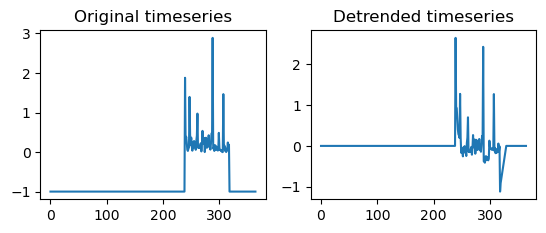

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3/4)


ax2.plot(ts_example_detrend.to_numpy())
ax2.set_title('Detrended timeseries')
ax2.set_box_aspect(3/4)

plt.show()

Perform Augmented Dickey-Fuller test of example of timeseries **after** trend removal

In [25]:
adf = adfuller(ts_example_detrend)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -5.534207730475937
p-value: 1.7596809178040187e-06
Critical values:
1%: -3.448905534655263
5%: -2.8697161816205705
10%: -2.5711258103550882


Remove trends for all timeseries found be non-stationary.

In [26]:
user_2019_detrend = user_2019.copy()

for col in non_stationary_idx_list:
    user_2019_detrend[col] = user_2019_detrend[col] - user_2019_detrend[col].rolling(window=12, min_periods=1).mean()

In [ ]:
user_2019_detrend.to_csv('../dataset/time_series_trendless.csv')

### Noise detection

To find the best sliding window for the noise we used the mean of the **sums of absolute differences (SAD)** between the original timeseries and the smoothed one, then we resorted to the elbow method to choose the best window that 'doesn't smooth too much' the original timeseries.

In [ ]:
noise_windows = np.array(range(1,21))

# Dict for all window sizes
mean_sad_dict = dict()

for window_size in tqdm(noise_windows):
    sum_abs_diff_users = list()

    for user_id in user_2019_detrend.columns:
        # Calculate SAD for each user
        sum_abs_diff_single_per_user = np.sum(np.abs(user_2019_detrend[user_id].rolling(window=window_size, center = True, min_periods = 1).mean() - user_2019_detrend[user_id]))
        sum_abs_diff_users.append(sum_abs_diff_single_per_user)
    
    # Average the SAD for all users to get final SAD score
    mean_sad_dict[window_size] = np.average(sum_abs_diff_users)

100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


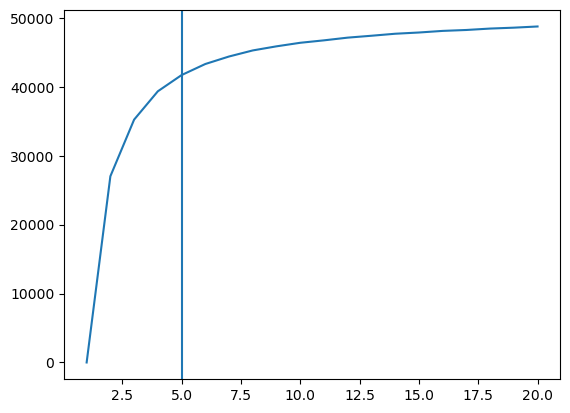

In [ ]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(5)
plt.show()

The result of this analisys is window size = 5

In [27]:
window_size = 5

In [28]:
# Function that denoises df of timeseries given a window size
def denoiser(df, window_size):
    denoised_df = df.apply(lambda ts : ts.rolling(window=window_size, center = True, min_periods = 1).mean())

    return denoised_df

Apply the denoising function to all timeseries.

In [29]:
user_2019_denoised = denoiser(user_2019_detrend, window_size=window_size)


Plot an example timeseries before and after denoising.

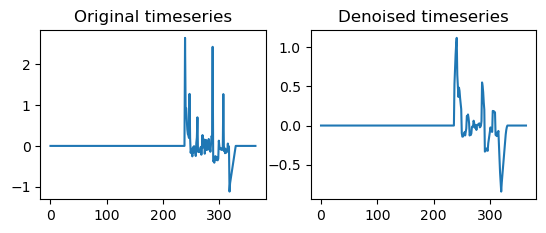

In [30]:
ts_example = user_2019_detrend[non_stationary_idx_list[4]]
ts_example_denoised = user_2019_denoised[non_stationary_idx_list[4]]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(ts_example.to_numpy())
ax1.set_title('Original timeseries')
ax1.set_box_aspect(3/4)

ax2.plot(ts_example_denoised.to_numpy())
ax2.set_title('Denoised timeseries')
ax2.set_box_aspect(3/4)


plt.show()

### Scaler with mean and std

Normalize the timeseries using Z-score normalization (mean and std)

In [31]:
# Apply normalization
user_2019_std = pd.DataFrame(columns=user_2019_denoised.columns)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  
for col in user_2019_denoised.columns:
    user_2019_std[col] = scaler.fit_transform(user_2019_denoised[col].values.reshape(1, -1)).flatten()

Show some examples of normalized timeseries.

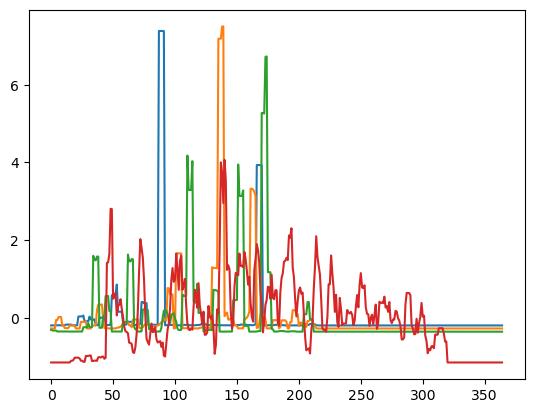

In [32]:
ts_example_1 = user_2019_std.iloc[:, 29]
ts_example_2 = user_2019_std.iloc[:, 567]
ts_example_3 = user_2019_std.iloc[:, 1000]
ts_example_4 = user_2019_std.iloc[:, 867]
plt.plot(ts_example_1.to_numpy())
plt.plot(ts_example_2.to_numpy())
plt.plot(ts_example_3.to_numpy())
plt.plot(ts_example_4.to_numpy())
plt.show()

Define the final dataset containing the preprocessed timeseries. Use transpose to have a timeseries for each row.

In [33]:
timeseries_data = np.transpose(user_2019_std.values)

## Clustering timeseries

In [34]:
def print_clusters(y, K, model):
    print("k = ", K, "| Clusters =", np.unique(y,return_counts=True)[1], "| Inertia =", model.inertia_)

In [35]:
# Function that plots sample of timeseries for each cluster

def plot_timeseries_per_cluster(labels, n_clusters):
    fig, ax = plt.subplots(math.ceil(n_clusters/2), 2)
    print(np.shape(ax))
    colors = plt.rcParams["axes.prop_cycle"]()
    fig.set_size_inches(8, 8)


    max_num_samples_per_cluster = 5
    for c in range(n_clusters):
        cluster_index = [i for i, x in enumerate(labels) if x == c] 
        random_indexes = np.random.choice(
            cluster_index, size=min(len(cluster_index), max_num_samples_per_cluster), replace=False)
        cluster_sample = timeseries_data[random_indexes]
        
        ax_idx_row = math.ceil(c/2)-1
        ax_idx_col = c % 2
        ax_c = ax[ax_idx_row][ax_idx_col]
        color = next(colors)["color"]
        ax_c.set_title('Cluster: '+str(c), y=1.0, pad=-14)
        for ts in cluster_sample:
            ax_c.plot(ts, color=color)

    plt.show()

### Shape-Based clustering
#### K-Means

In [36]:
from tslearn.clustering import TimeSeriesKMeans

Use euclidean metric

In [37]:
with warnings.catch_warnings(record=True):
    # Define lists of the K values for euclidean kmeans
    inertia_euclidean = list()
    models_euclidean = list()

    metric = 'euclidean'
    print("Clusters sizes for each K with", metric, "metric:")

    for n_clusters in range(2, 21):
        # Build and fit Kmeans
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=10)
        model.fit(timeseries_data)
        y = model.predict(timeseries_data)
        # Print cluster and inertia info
        print_clusters(y, n_clusters, model)

        inertia_euclidean.append(model.inertia_)
        models_euclidean.append(model)

Clusters sizes for each K with euclidean metric:
k =  2 | Clusters = [3284 3503] | Inertia = 248.30505727184908
k =  3 | Clusters = [2940 2851  996] | Inertia = 239.9066545780385
k =  4 | Clusters = [2796 2110 1176  705] | Inertia = 235.02292293018562
k =  5 | Clusters = [ 408 2109 2658 1158  454] | Inertia = 225.76722832630995
k =  6 | Clusters = [1846  339  949  442  382 2829] | Inertia = 221.66626677998318
k =  7 | Clusters = [1127  421 1403 2049  376  778  633] | Inertia = 218.64449060286842
k =  8 | Clusters = [ 406  395 2769  514 1701  412  318  272] | Inertia = 211.34858874881
k =  9 | Clusters = [1360 1835  426  431  268  330  805  342  990] | Inertia = 207.27685262872112
k =  10 | Clusters = [2092  370  185  113  218  317 1869  283  318 1022] | Inertia = 198.00238608757638
k =  11 | Clusters = [1633  443 1740  972  183  272  310  216  364  323  331] | Inertia = 192.56228930946986
k =  12 | Clusters = [ 150  322  845 1138  883  446  272  164  332  261  349 1625] | Inertia = 192

Now we plot the inertia curves of Kmeans with euclidean metrics to help the choice of the best K.

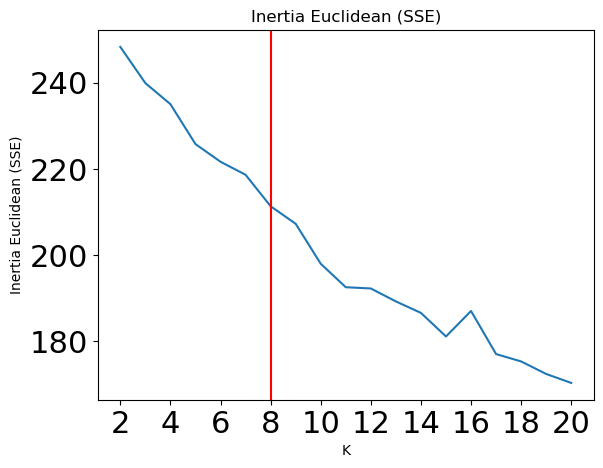

In [38]:
# Plot SSE with euclidean metric
plt.plot(range(2, len(inertia_euclidean) + 2), inertia_euclidean)
plt.ylabel('Inertia Euclidean (SSE)')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(np.arange(2,21,2))
plt.title('Inertia Euclidean (SSE)')
plt.axvline(8, color='r')
plt.show()

We choose K=8 as the best kmeans with euclidean metric, as, even it there is no clear elbow in the curve, it is a balanced number of clusters in terms of SSE and cluster sizes.

In [39]:
euclidean_n_clusters = 8
euclidean_kmeans = models_euclidean[euclidean_n_clusters-2]

(4, 2)


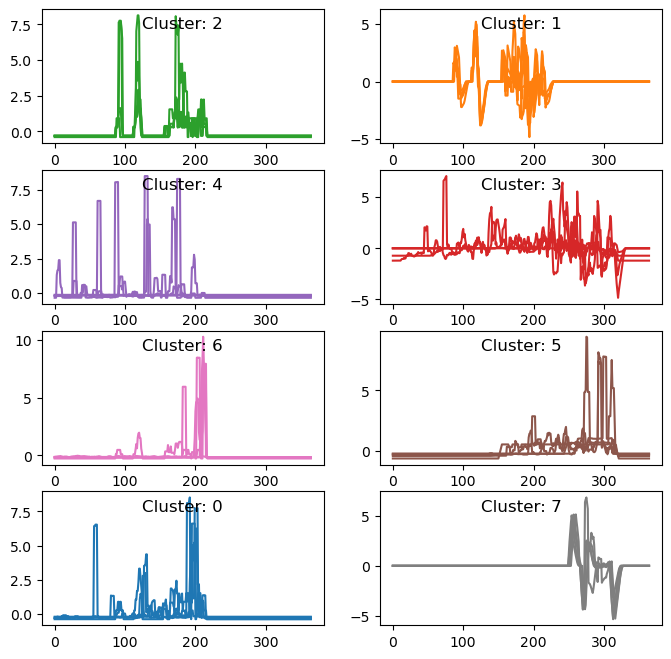

In [40]:
plot_timeseries_per_cluster(euclidean_kmeans.labels_, euclidean_n_clusters)

We can see that the major differences in the clusters are in the positions of peaks and pits in the timeseries.

Use same number of clusters of best K-means with euclidean metric to run K-means with **DTW** metric (too computationally expensive to try all K values).

In [41]:
metric = 'dtw'
dtw_n_clusters = 8

In [42]:
model = TimeSeriesKMeans(n_clusters=dtw_n_clusters, metric=metric, max_iter=10)
model.fit(timeseries_data)
y = model.predict(timeseries_data)
# Print cluster and inertia info
print("Clustering info for KMeans with", metric, "metric")
print_clusters(y, 8, model)

inertia_dtw = model.inertia_
model_dtw = model

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Clustering info for KMeans with dtw metric
k =  8 | Clusters = [1480  954  481 1557  979  373  295  668] | Inertia = 32.044820629558664


Now we show the timeseries for each cluster

(4, 2)


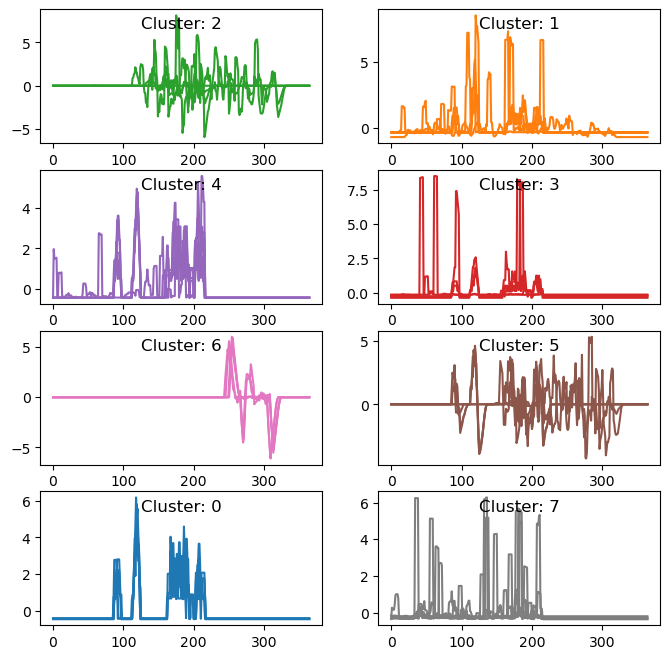

In [43]:
plot_timeseries_per_cluster(model_dtw.labels_, dtw_n_clusters)

DTW KMeans is similar to euclidean kmeans (some clusters seems to be equal such as DTW cluster 6 and euclidean cluster 3), but there are less clusters whcih have spikes in same positions.

### Feature based clustering

In [44]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [45]:
def calculate_features(values):
    # Define a set of features to extract from the timeseries
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

Extract features from timeseries

In [46]:
timeseries_features = [list(calculate_features(x).values())[:-2] for x in timeseries_data]

#### K-Means

Use minmax normalization for KMeans.

In [47]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

In [48]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [49]:
# Params for kmeans
clusters_list = [x for x in range(2, 20)]
init_value = 10
iter_value = 300

# Get list of kmeans with from the list of possible k
kmeans_list = KMeansFunction (X_minmax, clusters_list, init_value, iter_value)

# Calculate SSE for each kmeans
sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

100%|██████████| 18/18 [00:03<00:00,  4.92it/s]

k =  2 | Clusters = [3478 3309] | Inertia = 760.194674339011
k =  3 | Clusters = [ 471 3177 3139] | Inertia = 515.2936824118551
k =  4 | Clusters = [2540  701 3115  431] | Inertia = 381.7267393315975
k =  5 | Clusters = [ 361 1955 1939 1837  695] | Inertia = 304.09339875699663
k =  6 | Clusters = [1847 1607  694  286  495 1858] | Inertia = 260.17873021752905
k =  7 | Clusters = [1275 1193  283  691 1274 1634  437] | Inertia = 231.2309255457721
k =  8 | Clusters = [ 670  995 1600  280 1234  411 1219  378] | Inertia = 213.10262257365744
k =  9 | Clusters = [ 372 1604  167  406 1222  652  148 1224  992] | Inertia = 198.6657974148091
k =  10 | Clusters = [ 963  167  372  847  148  408 1122  652  891 1217] | Inertia = 181.1425343735921
k =  11 | Clusters = [ 867  840  182  652  436 1201 1083  372  135  889  130] | Inertia = 167.67523959037658
k =  12 | Clusters = [1095  127 1184  866  344  110  431  181  879  884  347  339] | Inertia = 160.14303704621102
k =  13 | Clusters = [523 433 170 13

Now we plot the SSE curve to help the choice of the best K.

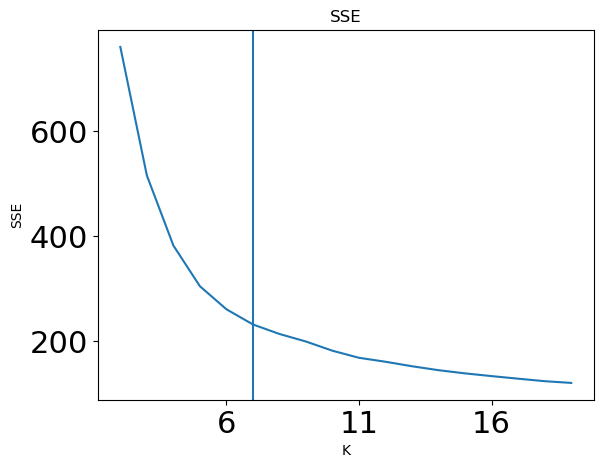

In [50]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(7)
plt.show()

In this case we choose K = 7 as we can deduct from the knee method. We can also see during the execution that from K=>7, there are 3 big clusters.

In [51]:
best_n_clusters = 7
best_kmeans = kmeans_list[best_n_clusters-2]

Now we show the timeseries for each cluster

(4, 2)


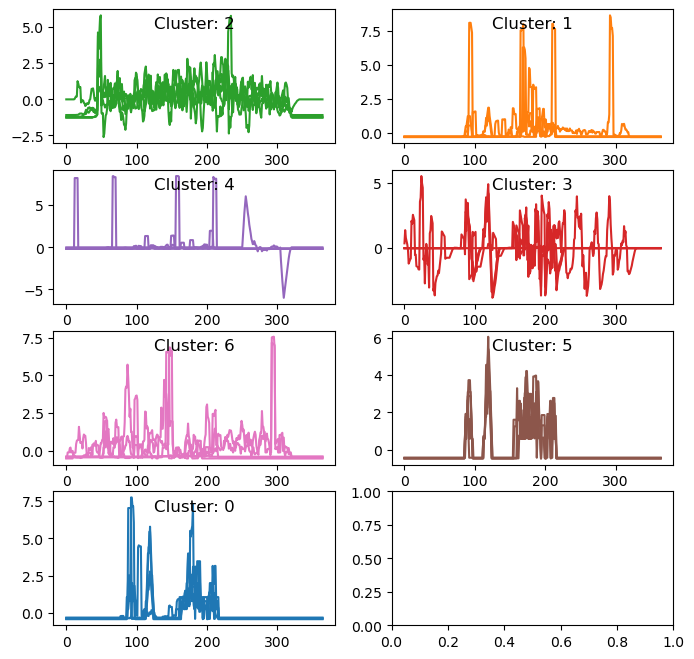

In [52]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

Feature based KMeans clustering seems to work well on the timeseries, clustering with good precision the ones with spikes in the same positions. It seems that it also separates in specific clusters the timeseries having negative spikes.

#### Hierachical

In [53]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata

Use both Z-score and minmax normalization.

In [54]:
scaler = StandardScaler()
X_std = scaler.fit_transform(timeseries_features)

In [55]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(timeseries_features)

##### With minmax normalization


In [56]:
config_hierarchical_minamx = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 0.35, n_clusters: 3

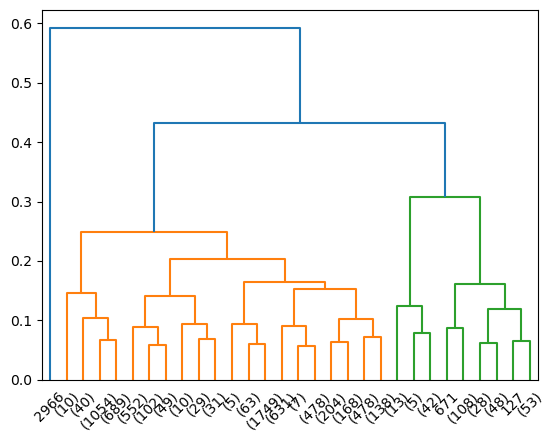

In [57]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=0.35, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.35, 'cosine', 'complete'))

method: ward, threshold: 2.0, n_clusters: 3

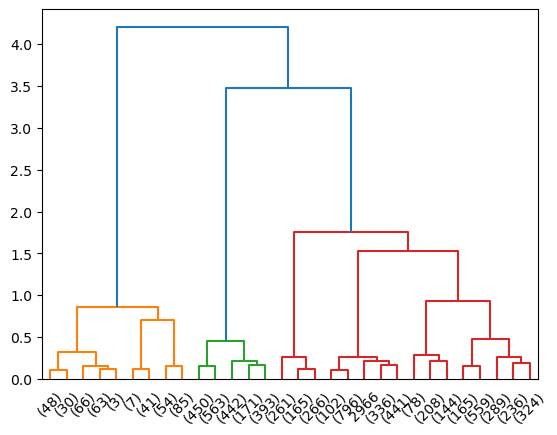

In [58]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=2.0, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((2.0, 'cosine', 'ward'))

method: average, threshold: 0.1, n_clusters: 3

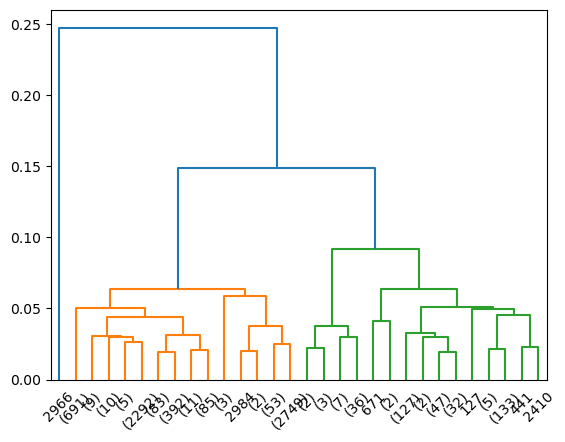

In [59]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.1, 'cosine', 'average'))

method: centroid, threshold: 0.1, n_clusters: 3

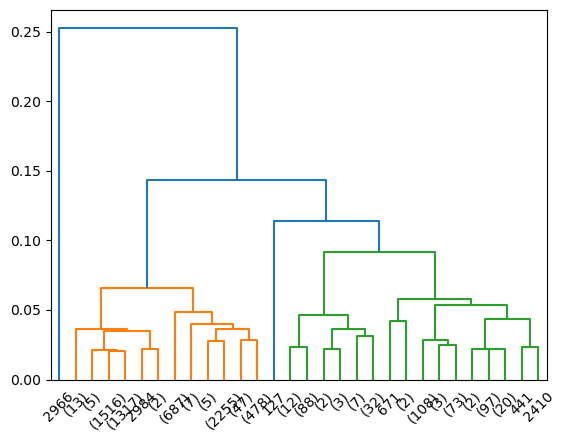

In [60]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.1, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [61]:
cluster_list_minmax = []
for treshold, metric_minmax, method_minmax in config_hierarchical_minamx:
    cluster = fclusterdata(X=X_minmax,
     t=treshold , criterion='distance', metric=metric_minmax, method=method_minmax)
     
    cluster_list_minmax.append(cluster)

Calculate Silhouette for each clustering.

In [62]:
for i, clustering in enumerate(cluster_list_minmax):
    treshold, metric, method = config_hierarchical_minamx[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_minmax, clustering)
    except:
        silhouette = np.nan
    print("MINMAX - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

MINMAX - dist: cosine , method: complete , SILHOUTTE: 0.48896769511911664 , n_clusters: 3
Clusters Size: [6487, 299, 1]


MINMAX - dist: cosine , method: ward , SILHOUTTE: 0.36124494586213873 , n_clusters: 3
Clusters Size: [397, 2019, 4371]


MINMAX - dist: cosine , method: average , SILHOUTTE: 0.46885972517645974 , n_clusters: 3
Clusters Size: [6386, 400, 1]


MINMAX - dist: cosine , method: centroid , SILHOUTTE: 0.43882611076652583 , n_clusters: 4
Clusters Size: [6333, 452, 1, 1]




Now we show the timeseries for one of the minmax hierarchical clusterings that shows only 1 big cluster and 2 smaller ones. We choose the one with *centroid* method.

In [63]:
chosen_hierarc_minmax = np.array(cluster_list_minmax[3]) - 1
chosen_n_clusters = len(np.unique(chosen_hierarc_minmax))

(2, 2)


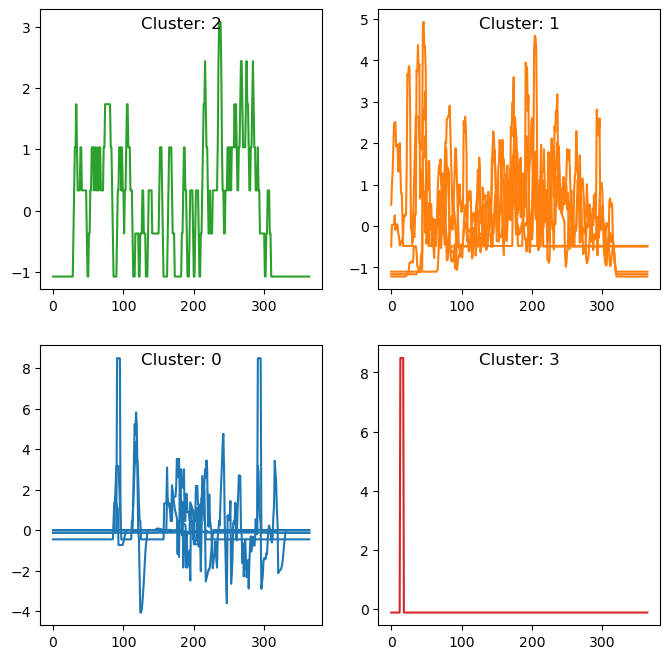

In [64]:
plot_timeseries_per_cluster(chosen_hierarc_minmax, chosen_n_clusters)

We can see that the timeseries in the bigger cluster have no negative values (no pits under 0) while the smaller one has negative peaks.

##### With mean-std normalization


In [65]:
config_hierarchical_std = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 1.65, n_clusters: 9

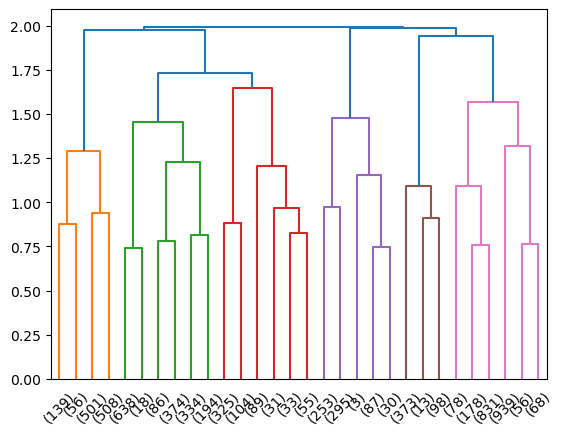

In [66]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=1.65, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((1.65, 'cosine', 'complete'))

method: ward, threshold: 14, n_clusters: 7

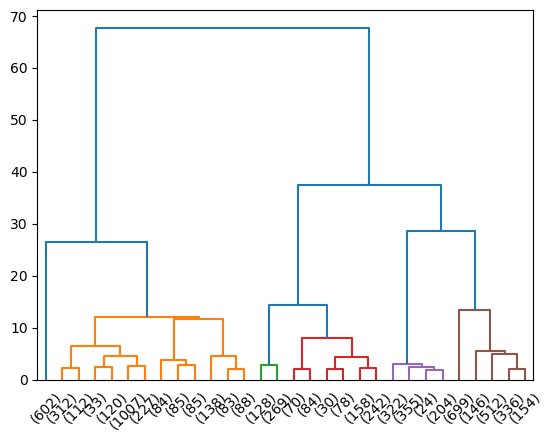

In [67]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=14, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((14, 'cosine', 'ward'))

method: average, threshold: 0.8, n_clusters: 5

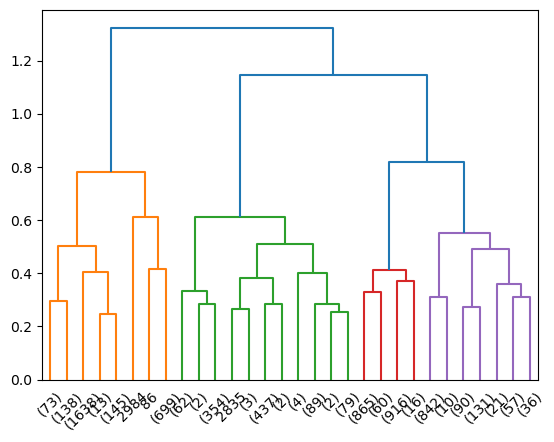

In [68]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.8, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.8, 'cosine', 'average'))

method: centroid, threshold: 0.7, n_clusters: 7

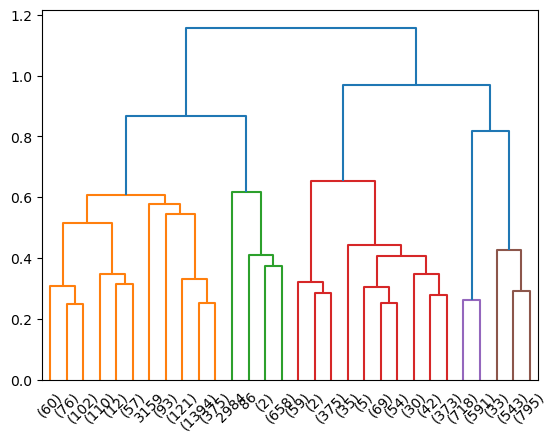

In [69]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.7, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.7, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [70]:
cluster_list_std = []
for treshold, metric_std, method_std in config_hierarchical_std:
    cluster = fclusterdata(X=X_std,
     t=treshold , criterion='distance', metric=metric_std, method=method_std)
     
    cluster_list_std.append(cluster)

Calculate Silhouette for each clustering.

In [71]:
for i, clustering in enumerate(cluster_list_std):
    treshold, metric, method = config_hierarchical_std[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_std, clustering)
    except:
        silhouette = np.nan
    print("STD - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

STD - dist: cosine , method: complete , SILHOUTTE: 0.2721009155671622 , n_clusters: 6
Clusters Size: [1204, 1644, 637, 668, 484, 2150]


STD - dist: cosine , method: ward , SILHOUTTE: 0.3987927474482378 , n_clusters: 6
Clusters Size: [602, 2374, 397, 662, 905, 1847]


STD - dist: cosine , method: average , SILHOUTTE: 0.33677752540907097 , n_clusters: 4
Clusters Size: [2708, 1035, 1857, 1187]


STD - dist: cosine , method: centroid , SILHOUTTE: 0.3969087308084885 , n_clusters: 5
Clusters Size: [2401, 662, 1044, 1309, 1371]




The final chosen hierarchical cluster selected is the one with **ward** method and **std** normalization, as it has an appropriate number of clusters and elements for each clusters, a dendrogram with well distanciated branches and relatively higher Silhouette for its number of clusters.

In [72]:
best_hierarchical = np.array(cluster_list_std[1]) - 1
best_n_clusters = len(np.unique(best_hierarchical))

We plot the timeseries for the hierarchical clustering with with **ward** method and **std** normalization.

(3, 2)


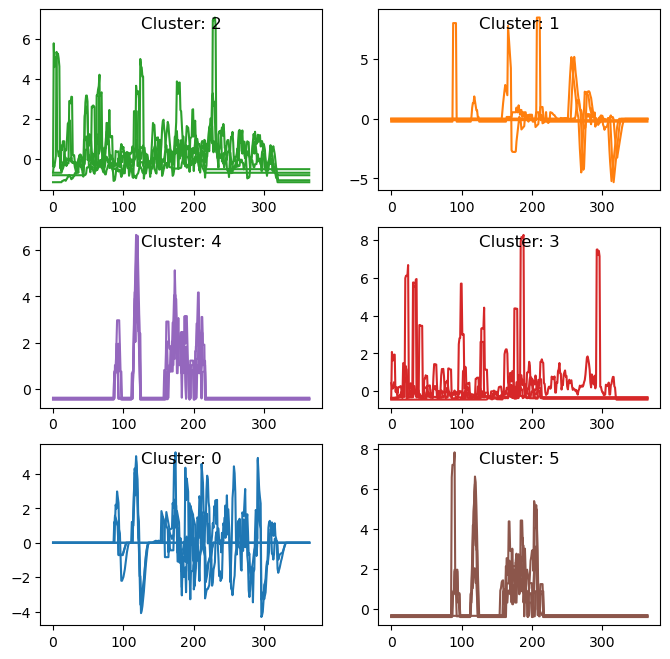

In [73]:
plot_timeseries_per_cluster(best_hierarchical, best_n_clusters)

Hierarchical seems to have clusters which have less coincidence in the positions of spikes, compared to KMeans. In particular cluster 0 seems to have many timeseries with negative spikes.

### Compression based clustering

In [74]:
from tslearn.piecewise import PiecewiseAggregateApproximation

We use PAA as the compression.

In [75]:
n_paa_segments = 27

paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(timeseries_data)

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Show PAA transformed timeseries

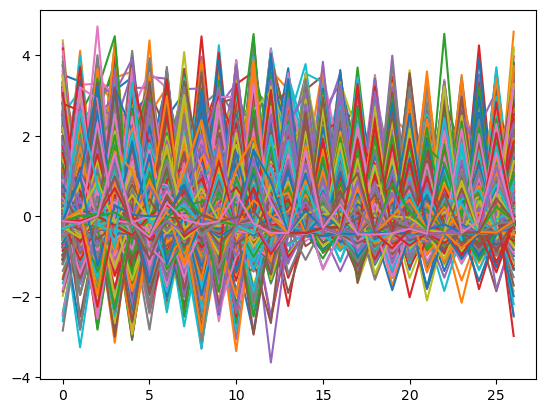

In [76]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [77]:
def TSKMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=5):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = TimeSeriesKMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value, random_state=0, metric='euclidean')
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [78]:
# Params for kmeans
clusters_list = [x for x in range(2, 21)]
init_value = 5
iter_value = 10

# Get list of kmeans with from the list of possible k
kmeans_list = TSKMeansFunction (X_minmax, clusters_list, init_value, iter_value)

# Calculate SSE for each kmeans
sse_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)

100%|██████████| 19/19 [03:02<00:00,  9.63s/it]

k =  2 | Clusters = [3317 3470] | Inertia = 0.11200817223345848
k =  3 | Clusters = [3139 3177  471] | Inertia = 0.07592363082538017
k =  4 | Clusters = [3114 2541  431  701] | Inertia = 0.05624393568623761
k =  5 | Clusters = [1955 1837  695  361 1939] | Inertia = 0.04480530115485779
k =  6 | Clusters = [1857  694 1848  286  495 1607] | Inertia = 0.03833545793147598
k =  7 | Clusters = [ 419 1559  693 1001 1737 1098  280] | Inertia = 0.03527077698922849
k =  8 | Clusters = [1005 1585  283  378  968  463  670 1435] | Inertia = 0.03178305601990579
k =  9 | Clusters = [ 685 1198  872  278  454 1093  927 1141  139] | Inertia = 0.029309638986100887
k =  10 | Clusters = [ 815 1203  436  670  277  891  378 1070  935  112] | Inertia = 0.0268330429566678
k =  11 | Clusters = [ 443  871 1087  154  151  917  370 1175  828  649  142] | Inertia = 0.024775528608750992
k =  12 | Clusters = [ 880  371  182  524  777  434  652  804  144  130 1056  833] | Inertia = 0.023508561768244337
k =  13 | Cluste

Now we plot the SSE curve to help the choice of the best K.

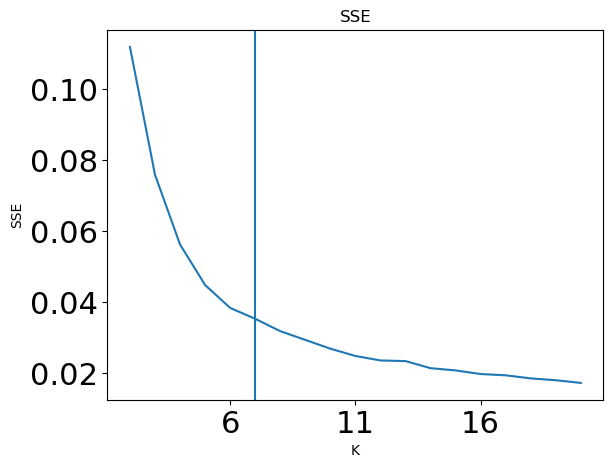

In [79]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(7)
plt.show()

The best K according to the SSE knee method is K=7

In [80]:
best_n_clusters = 7
best_kmeans = kmeans_list[best_n_clusters-2]

Now we show the timeseries for each cluster

(4, 2)


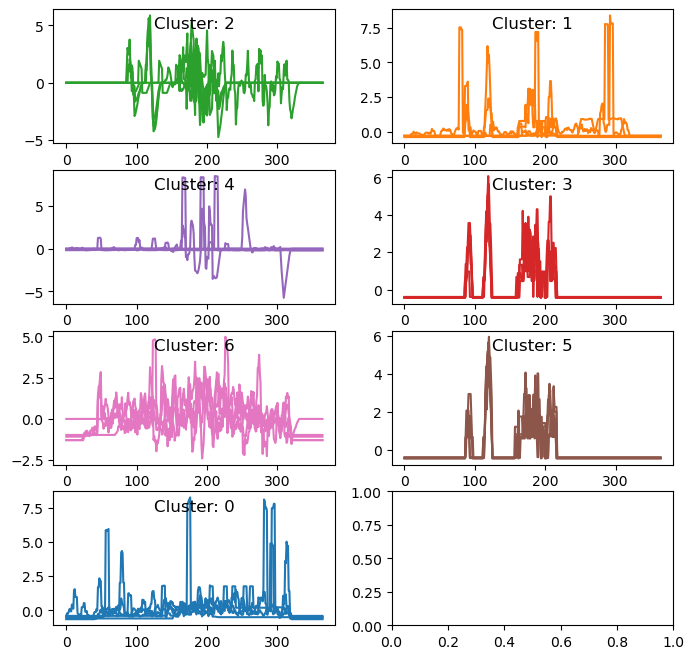

In [81]:
plot_timeseries_per_cluster(best_kmeans.labels_, best_n_clusters)

Clustering is similar to the one obtained with shape clustering, but some clusters (such as 4 and 3) seems to have less recognizable common patterns for the timeseries.

Show cluster centers for each cluster of the compressed timeseries next to the cluster means of the original timeseries.

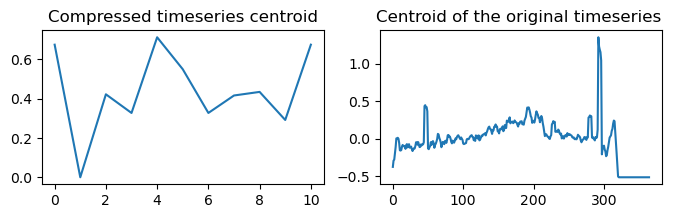

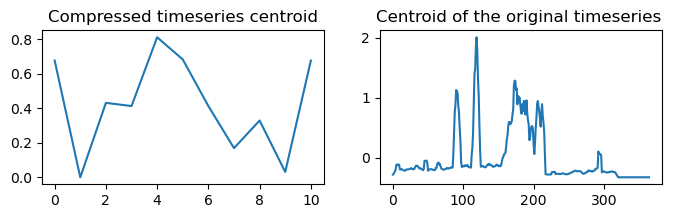

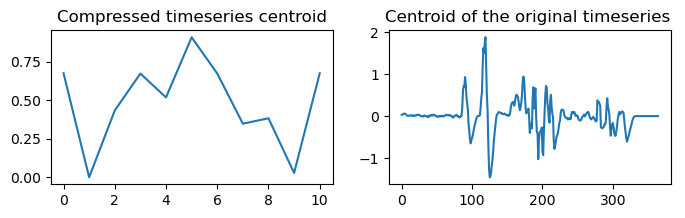

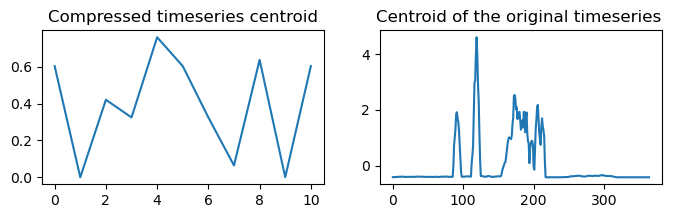

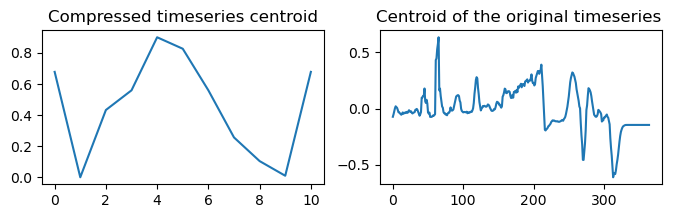

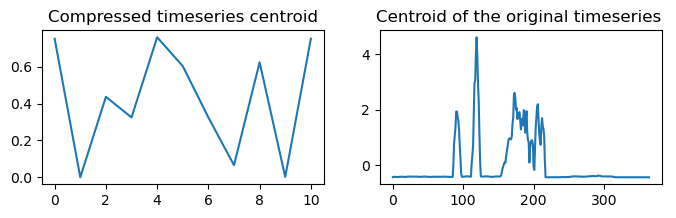

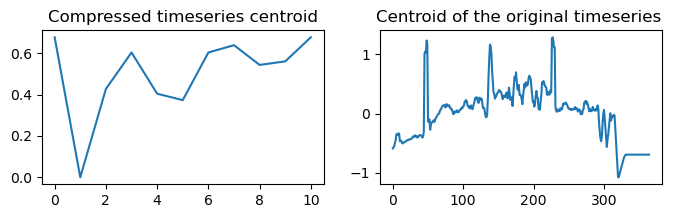

In [82]:
for c in range(best_n_clusters):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(best_kmeans.cluster_centers_[c])#.reshape(X_paa.shape[1], best_n_clusters))
    ax1.set_title("Compressed timeseries centroid")

    ax2.plot(np.mean(timeseries_data[np.where(best_kmeans.labels_ == c)], axis=0))
    ax2.set_title("Centroid of the original timeseries ")
    
    fig.set_size_inches(8, 2)
    plt.show()

It seems there is not much correspondance between PAA timeseries centroid and average cluster of the original timeseries.

## Shapelets

In [336]:
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
import tensorflow as tf

In [337]:
timeseries_data = np.transpose(user_2019_std.values)

In [338]:
user_2019_bot.head()

,bot
user_id,
722623,0
755746,0
806975,0
887281,0
1382561,0


Get labels of each timeseries

In [339]:
labels = np.transpose(user_2019_bot.values)


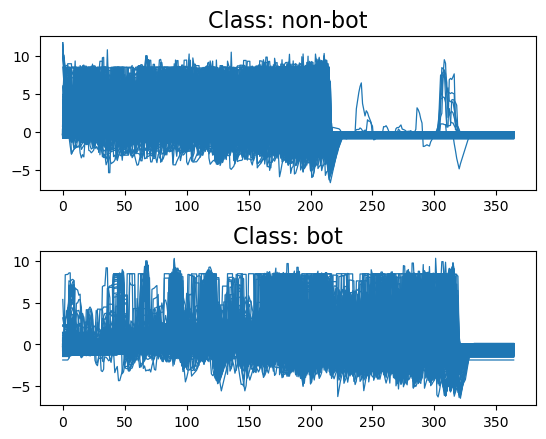

In [340]:
plt.figure()
for i, classe in enumerate(['non-bot', 'bot']):
    plt.subplot(2, 1, i + 1)
    mask = labels == i
    for x in timeseries_data[mask[0]]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)
    

plt.subplots_adjust(hspace=0.4)

plt.show()

In [341]:
mask = labels == 0
non_bot_ts = timeseries_data[mask[0]]
mask = labels == 1
bot_ts = timeseries_data[mask[0]]

Use grabocka method to identify the number of shapelets for each shapelet size

In [342]:
n_ts, ts_sz = timeseries_data.shape
n_classes = 2

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.02,
                                                       r=3)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 6787
ts_sz 365
n_classes 2
shapelet_sizes {7: 6, 14: 6, 21: 6}


Build the shapelet model to extract shapelet. We use shapelet sizes and numbers from previous grabocka method.

In [346]:
'''shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=100,
                        verbose=1)
'''
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.002,
                            max_iter=10,
                            random_state=42,
                            verbose=1)

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\tslearn\shapelets\shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


In [ ]:
labels = np.transpose(user_2019_bot.values)
labels = labels.reshape(labels.shape[1])
print(labels.shape)

Fit the shapelet model

In [348]:
shp_clf.fit(timeseries_data, labels)

Epoch 1/10
425/425 [==============================] - 23s 51ms/step - loss: 0.6426 - binary_accuracy: 0.6560 - binary_crossentropy: 0.6387
Epoch 2/10
425/425 [==============================] - 18s 42ms/step - loss: 0.6008 - binary_accuracy: 0.6988 - binary_crossentropy: 0.5963
Epoch 3/10
425/425 [==============================] - 15s 34ms/step - loss: 0.5842 - binary_accuracy: 0.7137 - binary_crossentropy: 0.5792
Epoch 4/10
425/425 [==============================] - 15s 35ms/step - loss: 0.5751 - binary_accuracy: 0.7289 - binary_crossentropy: 0.5695
Epoch 5/10
425/425 [==============================] - 14s 34ms/step - loss: 0.5738 - binary_accuracy: 0.7285 - binary_crossentropy: 0.5677
Epoch 6/10
425/425 [==============================] - 15s 35ms/step - loss: 0.5706 - binary_accuracy: 0.7276 - binary_crossentropy: 0.5642
Epoch 7/10
425/425 [==============================] - 14s 33ms/step - loss: 0.5667 - binary_accuracy: 0.7304 - binary_crossentropy: 0.5599
Epoch 8/10
425/425 [=======

LearningShapelets(batch_size=16, max_iter=10,
                  n_shapelets_per_size={7: 6, 14: 6, 21: 6},
                  optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x0000020A477927C8>,
                  random_state=42, verbose=1, weight_regularizer=0.002)

In [349]:
labels_non_bot = labels[labels==0]
predicted_labels_non_bot = shp_clf.predict(non_bot_ts)
print("Correct classification rate:", accuracy_score(labels_non_bot, predicted_labels_non_bot))
predicted_locations_non_bot = shp_clf.locate(non_bot_ts)

182/182 [==============================] - 1s 4ms/step
Correct classification rate: 0.6219093406593407
182/182 [==============================] - 0s 2ms/step


In [350]:
labels_bot = labels[labels==1]
predicted_labels_bot = shp_clf.predict(bot_ts)
print("Correct classification rate:", accuracy_score(labels_bot, predicted_labels_bot))
predicted_locations_bot = shp_clf.locate(bot_ts)

243/243 [==============================] - 1s 3ms/step
Correct classification rate: 0.8069677419354838
243/243 [==============================] - 1s 2ms/step


In [351]:
predicted_labels = shp_clf.predict(timeseries_data)
print("Correct classification rate:", accuracy_score(labels, predicted_labels))
predicted_locations = shp_clf.locate(timeseries_data)

425/425 [==============================] - 1s 3ms/step
Correct classification rate: 0.7275674082805363
425/425 [==============================] - 1s 2ms/step


Print all the shapelets

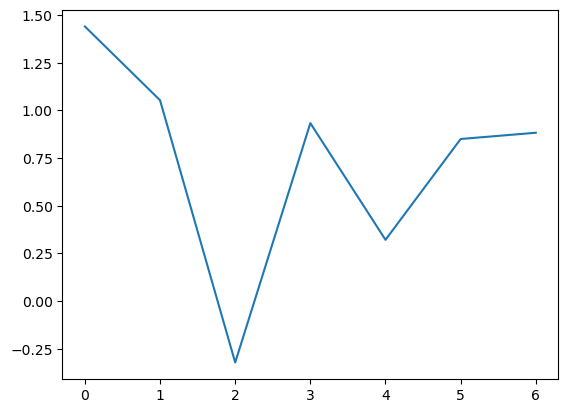

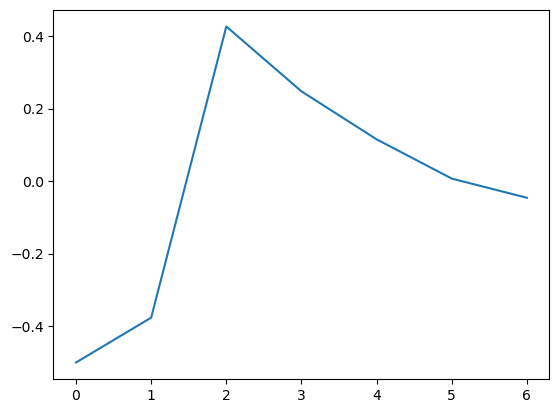

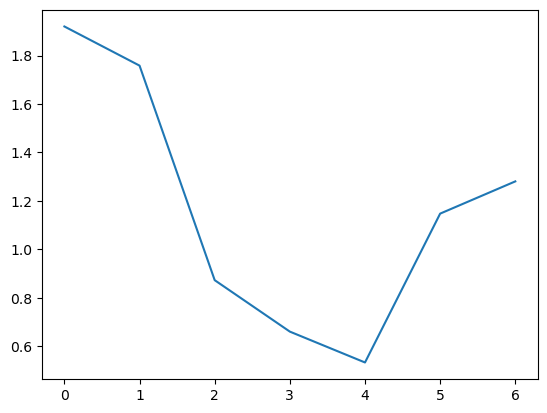

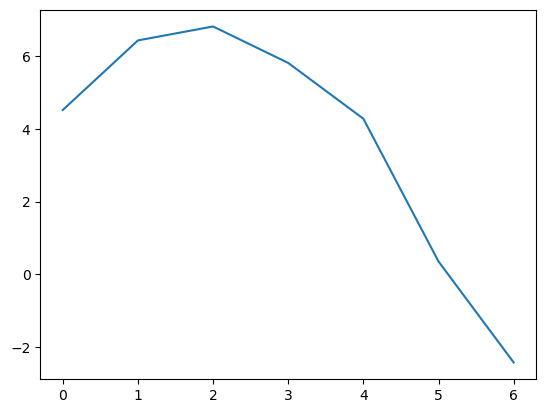

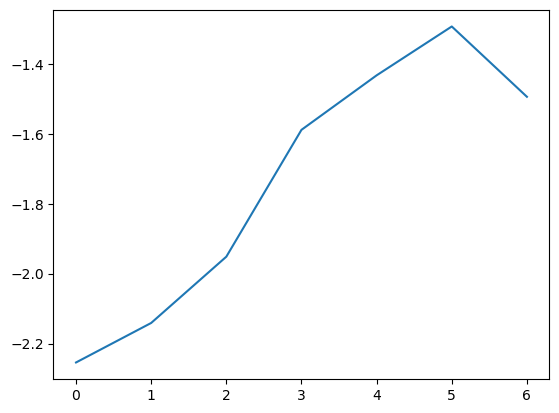

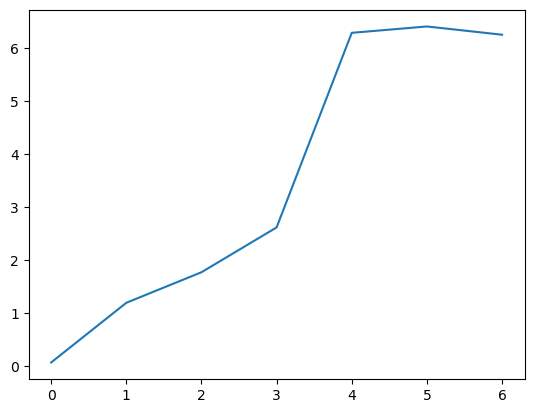

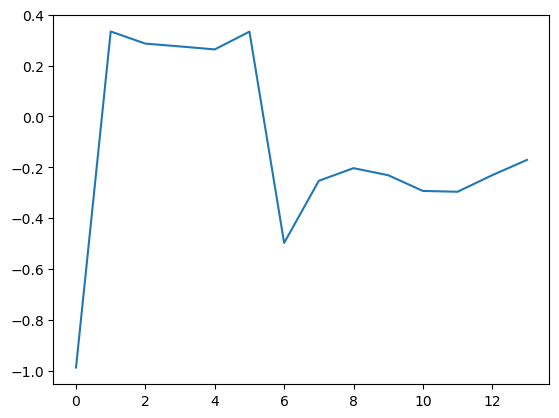

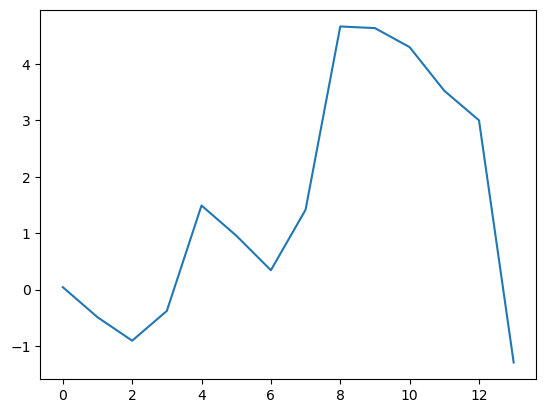

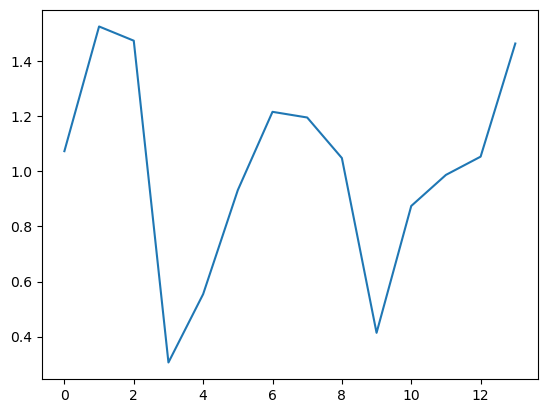

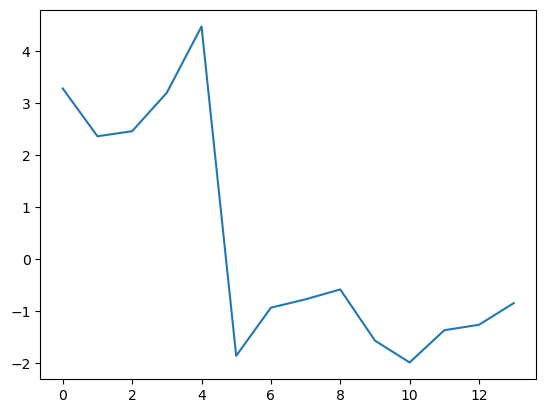

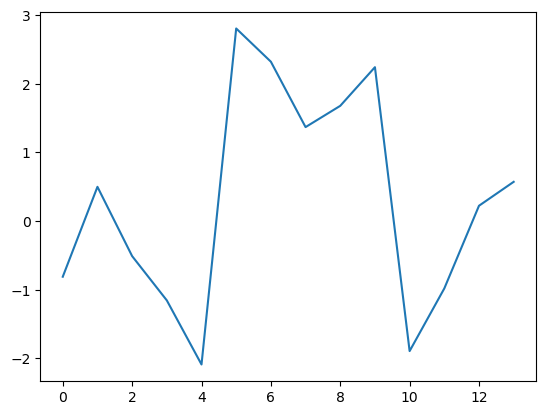

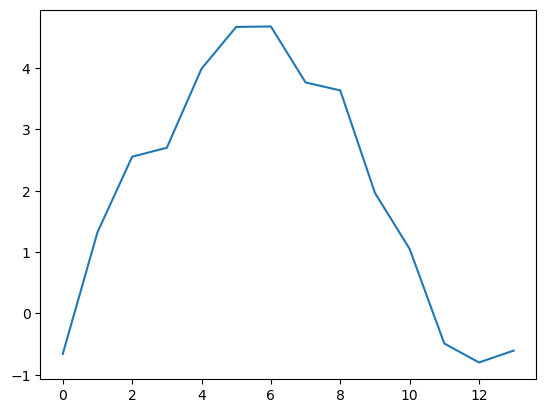

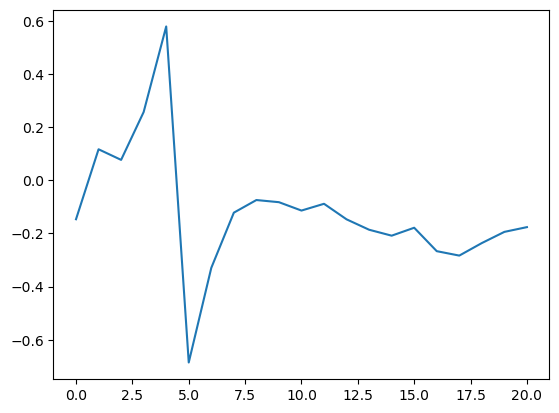

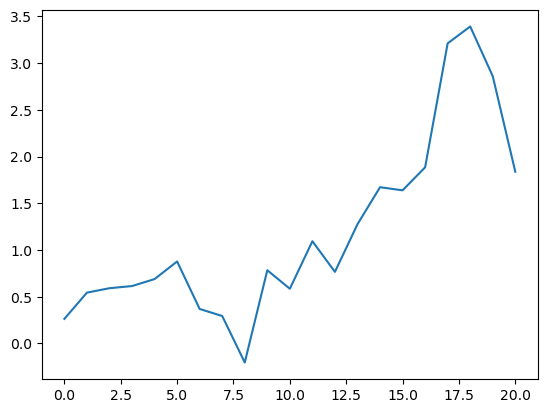

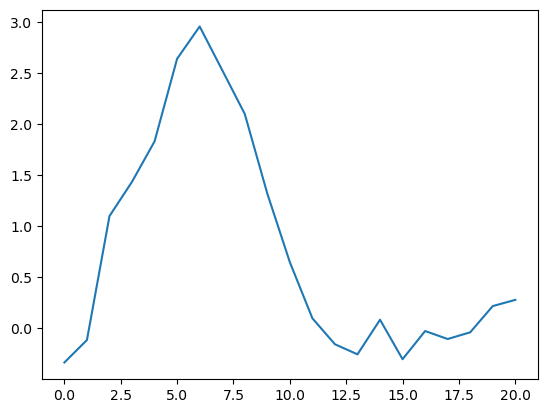

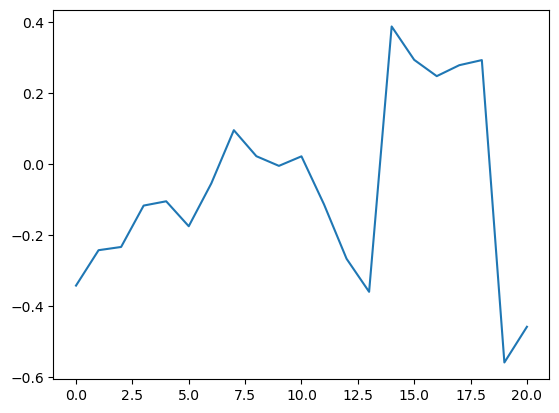

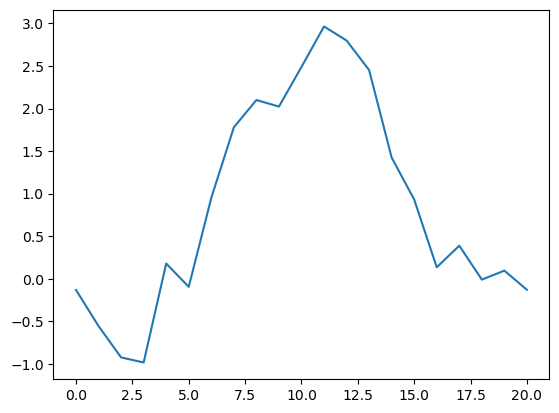

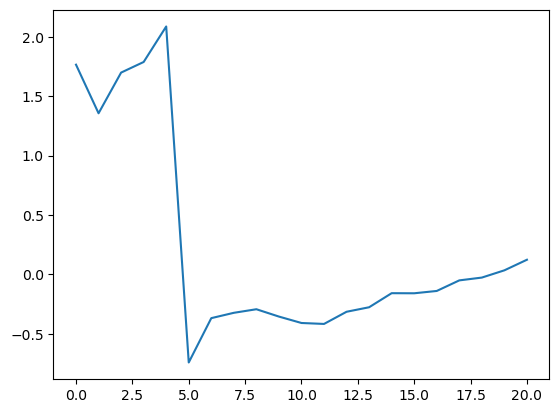

In [352]:
len(shp_clf.shapelets_as_time_series_)
for shp in shp_clf.shapelets_as_time_series_:
    plt.plot(shp)
    plt.show()

In [ ]:
#7 11 17 2000

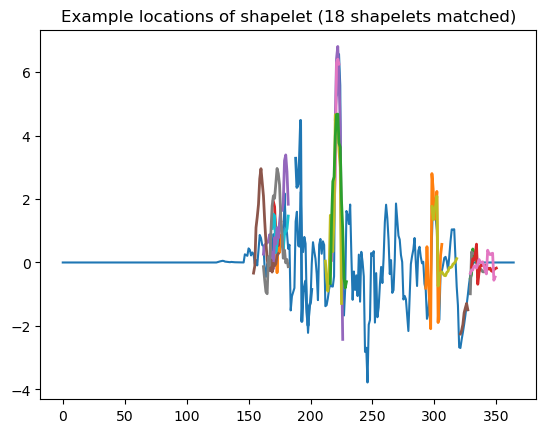

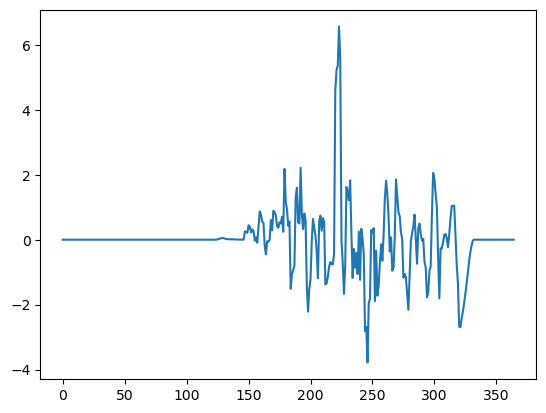

In [386]:
ts_id = 2000

#plt.figure()
n_shapelets = sum(shapelet_sizes.values())


plt.plot(timeseries_data[ts_id].ravel())
count = 0
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    if t0 > 0:
        plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
        count+=1
plt.title("Example locations of shapelet ({} shapelets matched)".format(count))
plt.show()
plt.plot(timeseries_data[ts_id].ravel())
plt.show()
